In [1]:
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt
from tqdm.notebook import tqdm
from numba.typed import Dict
from scipy import sparse


from ABCA7lof2.setup import get_data, save_all, save_annotations, subset_mat
from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts, log_normalize_counts, get_fraction_mito, filter_cells_by_mito

from ABCA7lof2.annotation import get_major_annotations
from ABCA7lof2.singlecell import bulk_data, expressed_fraction

config.THREADING_LAYER = 'workqueue'

In [2]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'

# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


In [3]:
# run initial cell filtering
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, 1, 500, 10000, plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf'), 'MT-', './processed_data/single_cell')

getting mito fractions
searching for best params
gaussian gridsearch
Number of components               5
Type of covariance         spherical
BIC score               64231.347606
Name: 4, dtype: object
All cells
150456
Mito keep
0.8863787419577817


  0%|          | 0/150456 [00:00<?, ?it/s]

All keep:
0.8683535385760621
Mito fraction mean discard:
0.19086041818417085
Mito fraction mean keep:
0.014229984155650754


  0%|          | 0/130649 [00:00<?, ?it/s]

In [237]:
# run PCA
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations('./processed_data/single_cell/brain_marker_genes.csv', features[:,0], filtered_counts, total_counts, 1, 50, 10, './processed_data/single_cell', None)

using prior markers for reduction & annotation...
getting marker indices...
getting normalized marker matrix...


  0%|          | 0/130649 [00:00<?, ?it/s]

running pca...
estimating gaussian mixture model...
gaussian gridsearch
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START covariance_type=full, n_components=11.......................
[CV 1/5; 1/1] END covariance_type=full, n_components=11;, score=-2662296.196 total time=  25.3s
[CV 2/5; 1/1] START covariance_type=full, n_components=11.......................
[CV 2/5; 1/1] END covariance_type=full, n_components=11;, score=-2657745.495 total time=  40.0s
[CV 3/5; 1/1] START covariance_type=full, n_components=11.......................
[CV 3/5; 1/1] END covariance_type=full, n_components=11;, score=-2648449.413 total time=  39.4s
[CV 4/5; 1/1] START covariance_type=full, n_components=11.......................
[CV 4/5; 1/1] END covariance_type=full, n_components=11;, score=-2635684.851 total time=  29.5s
[CV 5/5; 1/1] START covariance_type=full, n_components=11.......................
[CV 5/5; 1/1] END covariance_type=full, n_components=11;, score=-2645237.840 tot

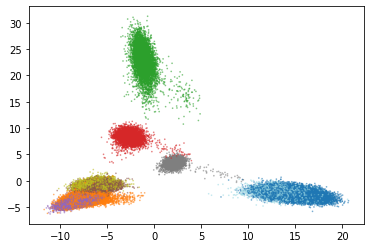

In [242]:
index = scores>-60
plt.pyplot.scatter(projected_matrix[index,0], projected_matrix[index,1], s=.5, alpha=0.5, c=predict[index],cmap='tab20')

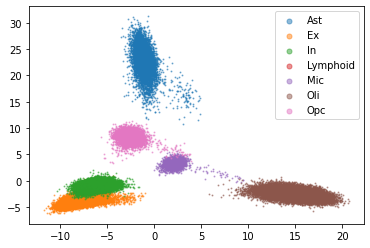

In [253]:
for i in np.unique(annotations):
    plt.pyplot.scatter(projected_matrix[index&(annotations==i),0], projected_matrix[index&(annotations==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)

In [256]:
np.unique(annotations[index], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U8'),
 array([ 6351, 44963, 13787,  2349, 29347,  5120]))

In [258]:
np.unique(annotations, return_counts=True)

(array(['Ast', 'Ex', 'In', 'Lymphoid', 'Mic', 'Oli', 'Opc'], dtype='<U8'),
 array([ 8667, 54794, 17352,  2086,  6170, 35361,  6219]))

In [259]:
np.sum(index)

101917

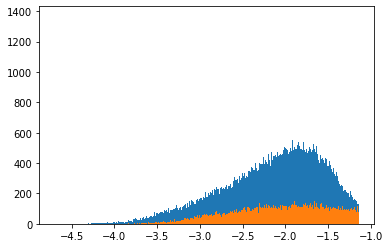

In [268]:
plt.pyplot.hist(np.log10(mito_fractions[index]+2e-5), 500)
plt.pyplot.hist(np.log10(mito_fractions[np.invert(index)]+2e-5), 500)
None

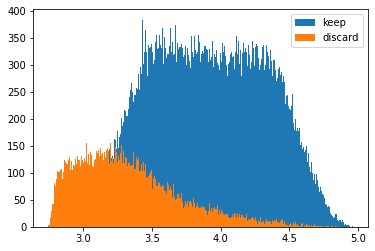

In [278]:
plt.pyplot.hist(np.log10(total_counts[index]+2e-5), 500, label='keep')
plt.pyplot.hist(np.log10(total_counts[np.invert(index)]+2e-5), 500, label='discard')
plt.pyplot.legend()
None

<Axes: >

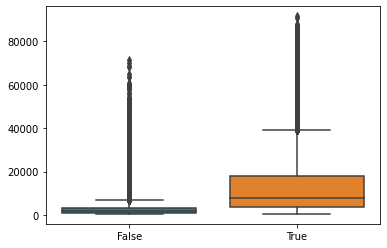

In [280]:
import seaborn as sns
sns.boxplot(x=index, y=total_counts)


<Axes: >

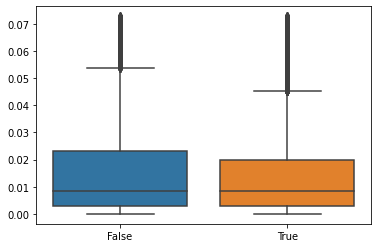

In [281]:
import seaborn as sns
sns.boxplot(x=index, y=mito_fractions)


In [ ]:
import seaborn as sns
sns.boxplot(x=index, y=total_counts)

In [ ]:
# plot log scores by cluster

In [ ]:
# filter log scores as above, update functions below

In [ ]:
# then do celltype annotations, --> regressing out batch before (or individual, decide) --> maybe do additional filtering based on node centrality --> and perhaps visualize with actionet

In [236]:
import numba as nb
import numpy as np
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from sklearn.mixture import GaussianMixture
from ABCA7lof2.qc import filter_cells_by_major_annotation
from ABCA7lof2.setup import process_metadata
from numba_progress import ProgressBar
import localreg
from ABCA7lof2.qc import gmm_bic_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def get_marker_indices(marker_path, gene_names):
    '''
    provides indices for celltype-marker genes in vector of gene names, as well as celltype-marker gene dictionary
    Args:
        marker_path string
            path to csv file containing marker gene annotations with the following columns: | marker | major_celltype |
            marker = gene names (must intersect with input to gene_names argument)
            major_celltype = indicating corresponding cell type
        gene_names: ndarray
            1D array containing gene names with '<U17' data type; array length = N-features
    '''
    print('getting marker indices...')
    markers = pd.read_csv(marker_path)
    dic = dict(zip(gene_names, range(0, len(gene_names))))
    targets = np.unique(np.array(markers['marker']))
    targets = targets[[targets[x] in set(gene_names) for x in range(len(targets))]]
    marker_indices = [dic[targets[x]] for x in range(len(targets))]
    celltype_dic = dict(zip(markers['marker'], markers['major_celltype']))
    return marker_indices, celltype_dic

@nb.njit(parallel=True)
def get_marker_matrix_norm(filtered_counts, marker_indices, marker_out, total_counts, progress_hook):
    '''
    returns normalized matrix of marker genes
    Args:
        filtered_counts ndarray
            2D array of counts post-cell-filtering
            N-cells x N-features
        marker_indices list
            column indices indicating marker genes in filtered_counts matrix
        marker_out numpy memmap
            N-cells x len(marker_indices)
        total_counts ndarray
            1D array of per-cell total counts, length = N-cells
    '''
    for i in nb.prange(filtered_counts.shape[0]):
        marker_out[i] = (filtered_counts[i][(marker_indices)])/total_counts[i]
        progress_hook.update(1)

def run_ipca(marker_mat, n_components_pca, sample_size):
    '''
    projects from marker-gene space onto principal components
    Args:
        marker_mat numpy memmap
            N-cells x len(marker_indices)
        n_components_pca integer
            number of PCA components to project cells onto
        sample_size: float
            0< float <=1 indicating the fraction of N-cells to sample and on which to run PCA
    '''
    print('running pca...')
    scaler = StandardScaler()
    marker_mat = scaler.fit_transform(marker_mat)
    ipca = IncrementalPCA(n_components_pca, batch_size=int(sample_size*marker_mat.shape[0]))
    ipca.fit(marker_mat)
    projected_matrix = ipca.transform(marker_mat) 
    return projected_matrix

def run_gaussian_mixture(projected_matrix, sample_size, n_components_gaussian):
    '''
    estimates gaussian mixture model based on data in PCA-space
    Args:
        projected_matrix ndarray
            2d-array N-cells x N-principal components
        n_components_gaussian integer
            number of gaussians to model
        sample_size: float
            0< float <=1 indicating the fraction of N-cells to sample and on which to estimate gaussian mixture model parameters
    '''
    print('estimating gaussian mixture model...')
    rand_index = np.random.choice(range(len(projected_matrix)), replace=False, size=int(sample_size*len(projected_matrix)))
    
    # first estimate N components and cov matrix
    X = projected_matrix[rand_index]
    
    ###############this code is from: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
    param_grid = {
        "n_components": range(11,12),
        "covariance_type": [ "full"],#"spherical", "tied", "diag",
    }
    print('gaussian gridsearch')
    
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, verbose=10
    )
    grid_search.fit(X)


    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
    df["mean_test_score"] = -df["mean_test_score"]
    df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    ###############

    x = df.loc[np.argmin(df['BIC score'])]
    print(x)

    gm = GaussianMixture(n_components=x[0], covariance_type=x[1], random_state=0).fit(X)
    predict = gm.predict(projected_matrix)
    scores = gm.score_samples(projected_matrix)
    return predict, scores

def get_celltype_summary_score_per_cell(unique_celltype_name, marker_out, celltype_name):
    '''
    get per-cell marker gene expression averages for each specified cell type label
    Args:
        unique_celltype_name ndarray
            enumeration of each cell type label being considered
        marker_out  numpy memmap
            N-cells x len(marker_indices)
        celltype_name ndarray
            celltype label corresponding to each marker gene in marker_gene names (i.e. marker_out column names); length = len(marker_indices)
    '''
    print('computing celltype summary scores...')
    celltype_summary_score = np.empty((len(unique_celltype_name), len(marker_out)))
    for i in range(len(unique_celltype_name)):
        index = celltype_name==unique_celltype_name[i]
        celltype_summary_score[i] = np.mean(marker_out[:, index], axis=1)
    return celltype_summary_score
      
def get_celltype_annotations_per_group(unique_celltype_name, celltype_summary_score, predictions):
    '''
    assigns cell type to each group based on marker genes
    Args:
        unique_celltype_name ndarray
            enumeration of each cell type label being considered
        celltype_summary_score  ndarray
            per-cell marker gene expression averages for each specified cell type label
            N-labels x N-cells
        predictions ndarray
            assigned gaussian based on gaussian mixture model
            length = N-cells
    '''
    print('annotating cell types...')
    cellgroup = np.unique(predictions)
    group_annotation_matrix = np.empty((len(cellgroup), len(celltype_summary_score)))
    for i in range(len(cellgroup)):
        index = np.array(predictions)==cellgroup[i]
        group_annotation_matrix[i] = np.mean(celltype_summary_score[:,index], axis = 1)
    group_annotation_matrix = group_annotation_matrix/(np.sum(group_annotation_matrix, axis = 0)) # normalization
    index = np.argmax(group_annotation_matrix, axis = 1)
    annotations_dic = dict(zip(cellgroup, unique_celltype_name[index]))
    return annotations_dic, group_annotation_matrix
    
def assign_major_celltypes(marker_genes, celltype_dic, marker_out, predictions):
    '''
    return per-cell cell type labels
    Args:
        marker_genes ndarray
            marker_out column names

        celltype_dic dictionary
            assigning each predicted gaussian label to a cell type annotation

        marker_out  numpy memmap
            N-cells x len(marker_indices)

        predictions ndarray
            assigned gaussian based on gaussian mixture model
            length = N-cells
    '''
    celltype_name = np.array([celltype_dic[marker_genes[x]] for x in range(len(marker_genes))])
    unique_celltype_name = np.unique(celltype_name)
    celltype_summary_score = get_celltype_summary_score_per_cell(unique_celltype_name, marker_out, celltype_name)
    annotations_dic, summary_score = get_celltype_annotations_per_group(unique_celltype_name, celltype_summary_score, predictions)
    annotations = np.array([annotations_dic[predictions[i]] for i in range(len(predictions))])
    return annotations

def get_predictions(filtered_counts, marker_indices, marker_out, total_counts, n_components_pca, sample_size, n_components_gaussian):
    '''
    returns cell labels that maximize probability of the data based on a pre-defined number of gaussian components
    Args:
       filtered_counts ndarray
            2D array of counts post-cell-filtering
            N-cells x N-features
        marker_indices list
            column indices indicating marker genes in filtered_counts matrix
        marker_out numpy memmap
            N-cells x len(marker_indices)
        total_counts ndarray
            1D array of per-cell total counts, length = N-cells
       n_components_pca integer
            number of PCA components to project cells onto
       sample_size: float
            0< float <=1 indicating the fraction of N-cells to sample for labeling
       n_components_gaussian integer
            number of gaussians to model
    '''
    print('getting normalized marker matrix...')
    with ProgressBar(total=filtered_counts.shape[0]) as numba_progress:
        get_marker_matrix_norm(filtered_counts, np.array(marker_indices), marker_out, total_counts, numba_progress)
    projected_matrix = run_ipca(marker_out, n_components_pca, sample_size)
    predict, scores = run_gaussian_mixture(projected_matrix, sample_size, n_components_gaussian)
    return projected_matrix, predict, scores
    
def get_major_annotations(marker_path, gene_names, filtered_counts, total_counts, sample_size, n_components_pca, n_components_gaussian, out_dir, infer_N_markers):
    '''
    return per-cell predicted cell type annotations
    Args:
        marker_path

        gene_names

        filtered_counts

        total_counts

        sample_size

        n_components_pca

        n_components_gaussian
    '''
    if infer_N_markers is not None:
        print('inferring markers for reduction & annotation...')
        marker_indices = infer_markers_for_reduction(infer_N_markers, filtered_counts)
        marker_out = np.memmap(out_dir + '/marker_matrix_norm.npy', mode='w+', shape=(filtered_counts.shape[0], len(marker_indices)), dtype='float')
        projected_matrix, predict, scores = get_predictions(filtered_counts, marker_indices, marker_out, total_counts, n_components_pca, sample_size, n_components_gaussian)
        marker_genes = gene_names[marker_indices]
        out_markers, out_fc = infer_marker_genes_per_cluster(marker_out, predict, marker_genes)
        annotations = np.concatenate((out_markers, out_fc))
    else:
        print('using prior markers for reduction & annotation...')
        marker_indices, celltype_dic = get_marker_indices(marker_path, gene_names)
        marker_out = np.memmap(out_dir + '/marker_matrix_norm.npy', mode='w+', shape=(filtered_counts.shape[0], len(marker_indices)), dtype='float')
        projected_matrix, predict, scores = get_predictions(filtered_counts, marker_indices, marker_out, total_counts, n_components_pca, sample_size, n_components_gaussian)
        marker_genes = gene_names[marker_indices]
        annotations = assign_major_celltypes(marker_genes, celltype_dic, marker_out, predict)
    return annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices

def infer_markers_for_reduction(infer_N_markers, filtered_counts):
    mean = get_log2(np.mean(filtered_counts, axis = 0))
    var = get_log2(np.var(filtered_counts, axis = 0))
    var_predictions = localreg.localreg(mean, var)
    mean_var_trend_removed = var-var_predictions
    marker_indices = np.argsort(-1*(mean_var_trend_removed + mean))[0:infer_N_markers]
    return marker_indices

def infer_marker_genes_per_cluster(marker_out, predict, marker_genes):
    n_markers = 20
    unique_predictions = np.unique(predict)
    out_fc = np.empty(shape=(len(unique_predictions), n_markers), dtype='float')
    out_markers = np.empty(shape=(len(unique_predictions), n_markers), dtype='<U17')
    for i in range(len(unique_predictions)):
        current_prediction = unique_predictions[i]
        FC = np.log2(np.mean(marker_out[np.where(predict==current_prediction)[0]], axis = 0)/np.mean(marker_out[np.where(predict!=current_prediction)[0]], axis = 0))
        indices = np.argsort(-1*FC)[0:n_markers]
        out_markers[i] = marker_genes[indices]
        out_fc[i] = FC[indices]
    return out_markers, out_fc

def get_log2(vals):
    vals+=np.min(vals[vals!=0])
    vals = np.log2(vals)
    return vals

# continue here --> save_all_data, save_data_by_celltype, qc_plots --> also think there is something wrong with the annotation function because it annotates all cells as Ast or Ex
# before make QC plots, make sure that everything is very clear in the code and write tests
# then use the QC plots to assess whether the metrics I am using make sense
# then add annotate_subtypes

#def annotate_subtypes(keep_cells, annotation, meta, marker_indices, n_components_pca, n_components_gaussian, sample_size, path_to_outputs):
#    cellnames = np.unique(annotation)
#    N = len(keep_cells)
#    predictions = np.empty(N).astype('str')
#    scores = np.empty(N)
#    for i in range(len(cellnames)):
#        name = cellnames[i]
#        index = np.where((keep_cells.astype('bool')) & (annotation==name))[0]
#        marker_out = np.memmap(path_to_outputs + '/marker_matrix_norm.npy', mode='w+', shape=(len(index), len(marker_indices)), dtype='float')
#        get_marker_matrix_norm(counts, np.array(marker_indices), marker_out, total_counts, keep_cells)
#        projected_matrix = run_ipca(marker_out, n_components_pca, sample_size)
#        predict, scr = run_gaussian_mixture(projected_matrix, sample_size, n_components_gaussian) # make N components adjustable after score report? Or use non-parametric strategy?
#        predictions[index] = [name + '.' + predict[x].astype('str') for x in range(len(predict))]
#        scores[index] = scr
#    print('concatenating metadata')
#    meta = np.concatenate((meta, predictions[:, None], scores[:, None]), axis=1)
#    return meta

In [ ]:
# logliklihood filtering
keep_cells_1 = filter_on_gaussian_logliklihood(scores)
individual_annotation = filtered_meta[:,2]
keep_cells_2, keep_cells_mito, keep_cells_individual, keep_genes, keep_individuals = filter_cells_by_major_annotation(mito_fractions, total_counts, 1, predict, individual_annotation, filtered_counts)

In [7]:
# compile metadata
filtered_meta_final = np.concatenate((filtered_meta,(keep_cells_1&keep_cells_2).reshape(-1,1), keep_cells_mito.reshape(-1,1), keep_cells_individual.reshape(-1,1), (scores>90).reshape(-1,1), predict.reshape(-1,1), scores.reshape(-1,1), annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((np.concatenate((np.array(['barcodes','index']), meta_col_names), axis=0), np.array(('keep_cells_all_per_celltype', 'keep_cells_mito_per_celltype', 'keep_cells_individual', 'keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)

In [8]:
# save data
np.save('./processed_data/single_cell/filtered_meta.npy', filtered_meta_final)
np.save('./processed_data/single_cell/meta_names.npy', meta_names)
np.save('./processed_data/single_cell/features.npy', features)
np.save('./processed_data/single_cell/projected_matrix.npy', projected_matrix)
np.save('./processed_data/single_cell/marker_indices.npy', marker_indices)
np.save('./processed_data/single_cell/keep_genes.npy', keep_genes)

In [9]:
# normalize counts
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 124282/124282 [01:39<00:00, 1243.94it/s]
